# Datos

In [1]:
!pip install tensorflow==2.17.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1


In [2]:
!pip install keras-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
# Configuración del backend para Keras
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, LSTM, concatenate, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import requests
import json
import gzip
import random
import re
from collections import defaultdict
from keras_hub.tokenizers import BertTokenizer

from io import StringIO
import urllib.request


In [ ]:
#Función auxiliar para ver ratings
def mas_cercano(x):
  opciones = [0, 0.25, 0.50, 0.75, 1]
  return min(opciones, key=lambda valor: abs(valor - x))

In [ ]:

DIR = './'

file_names = pd.read_csv(os.path.join('https://raw.githubusercontent.com/ssilvapinochet/RecSysData/refs/heads/main/dataset_names.csv'))
display(file_names)

file_name_type_mapping = dict(zip(file_names['name'].values, file_names['type'].values))
file_name_url_mapping = {}

for fname in file_name_type_mapping:
    ftype = file_name_type_mapping[fname]
    if ftype == "complete":
        url = 'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/'+fname
        file_name_url_mapping[fname] = url
    elif ftype == "byGenre":
        url = 'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/'+fname
        file_name_url_mapping[fname] = url



def download_by_name(fname, local_filename):
        if fname in file_name_url_mapping:
            url = file_name_url_mapping[fname]
            response = requests.get(url, stream=True)
            total_size_in_bytes= int(response.headers.get('content-length', 0))
            with open(local_filename, 'wb') as f:
                with tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True) as pbar:
                    for data in response.iter_content(chunk_size=8192):
                        pbar.update(len(data))
                        f.write(data)
            print('Dataset', fname, 'has been downloaded!')
        else:
            print('Dataset', fname, 'can not be found!')

,type,name
0,complete,goodreads_book_works.json.gz
1,complete,goodreads_book_authors.json.gz
2,complete,goodreads_book_series.json.gz
3,complete,goodreads_books.json.gz
4,complete,goodreads_book_genres_initial.json.gz
5,byGenre,goodreads_books_children.json.gz
6,byGenre,goodreads_books_comics_graphic.json.gz
7,byGenre,goodreads_books_fantasy_paranormal.json.gz
8,byGenre,goodreads_books_history_biography.json.gz
9,byGenre,goodreads_books_mystery_thriller_crime.json.gz


In [ ]:
OUT_DIR = "./reviews_all"
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

    output_path = os.path.join(OUT_DIR, 'goodreads_reviews_dedup.json.gz')
    download_by_name('goodreads_reviews_dedup.json.gz', output_path)

100%|██████████| 5.34G/5.34G [05:04<00:00, 17.6MiB/s]

Dataset goodreads_reviews_dedup.json.gz has been downloaded!


In [83]:
OUT_DIR = "./books_meta"
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

    output_path = os.path.join(OUT_DIR, 'goodreads_book_genres_initial.json.gz')
    download_by_name('goodreads_book_genres_initial.json.gz', output_path)

100%|██████████| 24.3M/24.3M [00:01<00:00, 13.0MiB/s]

Dataset goodreads_book_genres_initial.json.gz has been downloaded!


In [ ]:
OUT_DIR = "./books"
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

    output_path = os.path.join(OUT_DIR, 'goodreads_books.json.gz')
    download_by_name('goodreads_books.json.gz', output_path)

100%|██████████| 2.08G/2.08G [02:31<00:00, 13.7MiB/s]

Dataset goodreads_books.json.gz has been downloaded!


In [ ]:


def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)

            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [85]:
books_meta_gr = load_data('./books_meta/goodreads_book_genres_initial.json.gz', 10000000)

display(np.random.choice(books_meta_gr))

{'book_id': '34447865',
 'genres': {'fantasy, paranormal': 6,
  'mystery, thriller, crime': 2,
  'young-adult': 1}}

In [ ]:
books = load_data('./books/goodreads_books.json.gz', 10)

display(np.random.choice(books))

{'isbn': '1934876569',
 'text_reviews_count': '6',
 'series': ['151854'],
 'country_code': 'US',
 'language_code': '',
 'popular_shelves': [{'count': '515', 'name': 'to-read'},
  {'count': '25', 'name': 'fantasy'},
  {'count': '11', 'name': 'owned'},
  {'count': '11', 'name': 'books-i-own'},
  {'count': '9', 'name': 'currently-reading'},
  {'count': '9', 'name': 'favorites'},
  {'count': '9', 'name': 'magic'},
  {'count': '9', 'name': 'avalon'},
  {'count': '8', 'name': 'young-adult'},
  {'count': '6', 'name': 'series'},
  {'count': '6', 'name': 'fiction'},
  {'count': '5', 'name': 'books'},
  {'count': '4', 'name': 'childrens-books'},
  {'count': '4', 'name': 'owned-books'},
  {'count': '4', 'name': 'adventure'},
  {'count': '4', 'name': 'middle-grade'},
  {'count': '4', 'name': 'children'},
  {'count': '4', 'name': 'avalon-web-of-magic'},
  {'count': '3', 'name': 'ya'},
  {'count': '3', 'name': 'want'},
  {'count': '3', 'name': 'teen'},
  {'count': '3', 'name': 'faeries'},
  {'count'

In [88]:
#lo pasamos a dataframe
books_meta_gr = pd.DataFrame(books_meta_gr)
books_meta_gr.head()

,book_id,genres
0,5333265,"{'history, historical fiction, biography': 1}"
1,1333909,"{'fiction': 219, 'history, historical fiction,..."
2,7327624,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys..."
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri..."
4,287140,{'non-fiction': 3}


In [89]:
#Cuantos hay?
print(f"Hay {len(books_meta_gr)} libros en books_meta_gr")

Hay 2360655 libros en books_meta_gr


https://chatgpt.com/share/674b713c-ccb4-8005-b132-0fee92038efe

https://gilberttanner.com/blog/building-a-book-recommendation-system-usingkeras/

https://chatgpt.com/share/67320656-d4b4-8005-9c1e-b88ef5b1ffff

# Solo Reviews explícitas

In [ ]:
def mas_cercano(x):
  opciones = [0, 0.25, 0.50, 0.75, 1]
  return min(opciones, key=lambda valor: abs(valor - x))

# Nueva implementación de Reviews


In [ ]:


def load_data_random(file_name, head=500):
    with gzip.open(file_name, 'rt') as fin:
        result = []
        count = 0

        for line in fin:
            obj = json.loads(line.strip())

            if count == 0:
                #La primera línea siempre se incluye
                result.append(obj)
            elif head is not None and len(result) < head:
                #Llenamos el resultado hasta alcanzar el tamaño del input head
                result.append(obj)
            elif head is not None:
                #el muestreo
                idx = random.randint(1, count)  #y el 1 no cuenta pq es el index
                if idx < len(result):
                    result[idx] = obj

            count += 1

        return result

In [ ]:


#https://chatgpt.com/c/675345da-dce0-8005-b510-cec16e355c7b

def load_data_most_frequent_books(file_name):
    # Primero, contamos la frecuencia de book_id
    book_id_counts = {}

    with gzip.open(file_name, 'rt') as fin:
        for line in fin:
            obj = json.loads(line.strip())
            book_id = obj['book_id']
            book_id_counts[book_id] = book_id_counts.get(book_id, 0) + 1

    # Ordenamos los book_id por frecuencia y seleccionamos los 100 más frecuentes
    top_100_book_ids = sorted(book_id_counts, key=book_id_counts.get, reverse=True)[:1000]

    # Contamos cuántos de los top 100 libros han sido revisados por cada usuario
    user_book_count = {}

    with gzip.open(file_name, 'rt') as fin:
        for line in fin:
            obj = json.loads(line.strip())
            if obj['book_id'] in top_100_book_ids:
                user_id = obj['user_id']
                if user_id not in user_book_count:
                    user_book_count[user_id] = set()
                user_book_count[user_id].add(obj['book_id'])

    # Filtramos usuarios que han revisado al menos 15 libros de los top 100
    eligible_users = {user_id for user_id, books in user_book_count.items() if len(books) >= 50}

    # Ahora leemos el archivo de nuevo y seleccionamos las reviews según las condiciones:
    # 1. Reviews de los 100 libros más frecuentes
    # 2. Reviews de los usuarios que aparecen en al menos 15 de esos libros
    result = []
    user_review_counts = {}

    with gzip.open(file_name, 'rt') as fin:
        for line in fin:
            obj = json.loads(line.strip())
            user_id = obj['user_id']
            book_id = obj['book_id']

            # Condición para incluir reviews
            if book_id in top_100_book_ids and user_id in eligible_users:
                # Para usuarios de interés, limitar a 50 reviews
                if user_id in eligible_users:
                    user_review_counts[user_id] = user_review_counts.get(user_id, 0) + 1
                    # Solo agregar si no ha superado el límite de 50 reviews
                    # if user_review_counts[user_id] > 50:
                    #     continue

                result.append(obj)

    return result


In [ ]:
# reviews_gr = load_data('./reviews/goodreads_reviews_spoiler.json.gz', head=20000)
all_reviews_og = load_data_most_frequent_books('./reviews_all/goodreads_reviews_dedup.json.gz')

print(' == sample record (all reviews) ==')
display(np.random.choice(all_reviews_og))

 == sample record (all reviews) ==


{'user_id': '7271d9e263439ad48f5eac62aeba8eb9',
 'book_id': '43641',
 'review_id': '3b3266e54173510063cc742b37e9faa4',
 'rating': 4,
 'review_text': 'Hard to find a better read.',
 'date_added': 'Wed Jan 04 20:21:34 -0800 2012',
 'date_updated': 'Wed Jan 04 20:22:14 -0800 2012',
 'read_at': '',
 'started_at': '',
 'n_votes': 0,
 'n_comments': 0}

In [ ]:
all_reviews = all_reviews_og.copy()

In [ ]:
#book_id unicos
all_reviews_df = pd.DataFrame(all_reviews)
unique_book_ids = all_reviews_df['book_id'].unique()
print(f"Hay {len(unique_book_ids)} libros únicos en all_reviews.")

Hay 1000 libros únicos en all_reviews.


In [ ]:
#usuarios unicos
unique_user_ids = all_reviews_df['user_id'].unique()
print(f"Hay {len(unique_user_ids)} usuarios únicos en all_reviews.")

Hay 6800 usuarios únicos en all_reviews.


In [ ]:
#cuantos libros tiene cada usuario en promedio
books_per_user = all_reviews_df.groupby('user_id')['book_id'].nunique()
average_books_per_user = books_per_user.mean()
print(f"En promedio, cada usuario tiene {average_books_per_user:.2f} libros.")

En promedio, cada usuario tiene 78.21 libros.


In [ ]:
user_per_book = all_reviews_df.groupby('book_id')['user_id'].nunique()
average_users_per_book = user_per_book.mean()
print(f"En promedio, cada libro tiene {average_users_per_book:.2f} usuarios.")

En promedio, cada libro tiene 531.81 usuarios.


In [ ]:
def load_data_book_title(file_name, reviews_df=None):
    book_data = {}

    # Load all book data into a dictionary for efficient lookup
    with gzip.open(file_name, 'rt', encoding='utf-8') as fin:
        for line in fin:
            book = json.loads(line)
            book_data[book['book_id']] = book['title']

    # If reviews DataFrame is provided, add book_title column
    if reviews_df is not None:
        reviews_df['book_title'] = reviews_df['book_id'].map(book_data)

    return book_data, reviews_df

_, all_reviews_df = load_data_book_title('./books/goodreads_books.json.gz', all_reviews_df)

In [ ]:
all_reviews_df.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,book_title
0,4672eb229c808b792b8ea95f01f19784,7171637,47e542b17d8ac560a85dc47616347739,2,"Second read, I dropped one star. I remember ho...",Mon Jun 04 22:39:49 -0700 2012,Sun May 25 00:38:29 -0700 2014,Wed Apr 10 00:00:00 -0700 2013,Thu Apr 04 00:00:00 -0700 2013,0,0,"Clockwork Angel (The Infernal Devices, #1)"
1,4672eb229c808b792b8ea95f01f19784,7735333,40b2013caee903cc3813cc24f2aca022,4,I'm going to read this to finish up my dypstop...,Mon Jun 04 22:39:47 -0700 2012,Sun Dec 22 22:38:38 -0800 2013,Sun Dec 22 00:00:00 -0800 2013,Thu Dec 19 00:00:00 -0800 2013,0,0,"Matched (Matched, #1)"
2,4672eb229c808b792b8ea95f01f19784,3,5f8db523518efe9027d32fa4f3d56a62,3,I remember trying 3 times to read this but I a...,Mon Jun 04 22:39:18 -0700 2012,Sun Aug 30 00:05:04 -0700 2015,Sat Aug 22 15:27:54 -0700 2015,Wed Aug 19 00:00:00 -0700 2015,0,0,Harry Potter and the Sorcerer's Stone (Harry P...
3,4672eb229c808b792b8ea95f01f19784,41865,d543b61945f295c89857dd8d51829520,0,"(This, and the whole series) Needs a re-read. ...",Mon Jun 04 22:39:16 -0700 2012,Sun Feb 19 21:22:30 -0800 2017,,,0,0,"Twilight (Twilight, #1)"
4,4672eb229c808b792b8ea95f01f19784,13618440,195bd3ea29889a117a3bb3afee4294fc,4,The lore in this series is incredible. I absol...,Wed Apr 08 19:51:35 -0700 2015,Sat Apr 25 19:04:38 -0700 2015,Sat Apr 25 00:00:00 -0700 2015,Wed Apr 08 00:00:00 -0700 2015,1,0,Dreams of Gods & Monsters (Daughter of Smoke &...


In [ ]:
#print the uno random de all_reviews_df
random_row = all_reviews_df.sample(n=1)
print(random_row)

                                 user_id book_id  \
364844  fc42cbb17f863f27ab7b8b231ef6e49a   47212   

                               review_id  rating  \
364844  4a4bd03974912919ab1134a981c6aafa       0   

                                              review_text  \
364844  As a fantasy crime thriller this was an entert...   

                            date_added                    date_updated  \
364844  Tue Apr 12 06:48:34 -0700 2011  Sun Apr 21 03:18:49 -0700 2013   

       read_at started_at  n_votes  n_comments  \
364844                           1           0   

                                 book_title  
364844  Storm Front (The Dresden Files, #1)  


In [ ]:
#Sacamos los que tienen rating 0
# all_reviews = [review for review in all_reviews if review['rating'] != 0]

all_reviews_df = all_reviews_df[all_reviews_df["rating"] != 0]

In [ ]:
#all_reviews_df a csv
all_reviews_df.to_csv('all_reviews_df.csv', index=False)

all_reviews_df = pd.read_csv('all_reviews_df.csv')

In [ ]:
#https://chatgpt.com/c/674c6ca9-a940-8005-aa85-4af0edc31728


user_id_map = defaultdict(lambda: len(user_id_map) + 1)
book_id_map = defaultdict(lambda: len(book_id_map) + 1)

# # Transformar los valores en la lista de diccionarios
# for review in all_reviews_df:
#     review["user_id"] = user_id_map[review["user_id"]]
#     review["book_id"] = book_id_map[review["book_id"]]

# # Mostrar resultado
# print(" == Sample transformed reviews ==")
# display(np.random.choice(all_reviews_df))

user_id_map = defaultdict(lambda: len(user_id_map) + 1)
book_id_map = defaultdict(lambda: len(book_id_map) + 1)

# Transformar los valores en las columnas del DataFrame
all_reviews_df["user_id"] = all_reviews_df["user_id"].map(lambda x: user_id_map[x])
all_reviews_df["book_id"] = all_reviews_df["book_id"].map(lambda x: book_id_map[x])

# Mostrar resultado
print("== Sample transformed reviews ==")
print(all_reviews_df.sample(n=3))  # Muestra 3 filas aleatorias del DataFrame

== Sample transformed reviews ==
        user_id  book_id                         review_id  rating  \
487380     6388       51  b499aef7aed7e9e9e6777de76104c4b2       4   
80626      1049      127  7569c7351f1992393dd8c9cee0a3b55f       4   
83288      1085      248  b60948fcd158cda488f495e72a5a9372       5   

                                              review_text  \
487380  2015 reading challenge: A book with more than ...   
80626   she lost me after the lake thing... if this wa...   
83288   Epic. Beautiful. Raw. Heartbreaking. Unforgett...   

                            date_added                    date_updated  \
487380  Wed Jan 22 22:43:42 -0800 2014  Fri Jul 10 14:25:33 -0700 2015   
80626   Wed Dec 02 15:16:28 -0800 2015  Mon Dec 21 08:34:34 -0800 2015   
83288   Sun Mar 24 08:32:24 -0700 2013  Fri May 24 17:13:57 -0700 2013   

                               read_at                      started_at  \
487380  Wed Apr 29 00:00:00 -0700 2015  Wed Jan 22 00:00:00 -0800 2014

In [ ]:
#Guardar en JSON user_id_map y book_id_map

with open('user_id_map_10k.json', 'w') as f:
    json.dump(user_id_map, f)

with open('book_id_map_10k.json', 'w') as f:
    json.dump(book_id_map, f)

In [ ]:
# Cuantos book_id unicos hay?
# unique_book_ids_ar = {entry['book_id'] for entry in all_reviews}
unique_book_ids_ar = all_reviews_df['book_id'].unique()

# unique_book_ids_int = set(interactions['book_id'])

# Imprimir los resultados
print(f"Hay {len(unique_book_ids_ar)} book_id únicos en all_reviews.")
# print(f"Hay {len(unique_book_ids_int)} book_id únicos en interactions.")

Hay 1000 book_id únicos en all_reviews.


In [ ]:
# unique_user_ids_ar = {entry['user_id'] for entry in all_reviews}
unique_user_ids_ar = all_reviews_df['user_id'].unique()

# unique_user_ids_int = set(interactions['user_id'])

# Imprimir los resultados
print(f"Hay {len(unique_user_ids_ar)} user_id únicos en all_reviews.")
# print(f"Hay {len(unique_user_ids_int)} user_id únicos en interactions.")

Hay 6788 user_id únicos en all_reviews.


Distribución de ratings

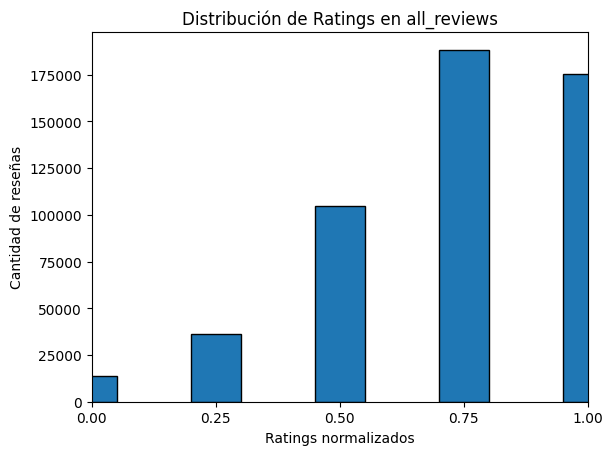

In [ ]:

ratings = all_reviews_df['rating']
ratings = (ratings - 1) / 4

unique_ratings, counts = np.unique(ratings, return_counts=True)

plt.bar(unique_ratings, counts, width=0.1, edgecolor='black')
plt.xlim(0, 1) 
plt.xticks(unique_ratings, labels=[f"{x:.2f}" for x in unique_ratings])
plt.xlabel('Ratings normalizados')
plt.ylabel('Cantidad de reseñas')
plt.title('Distribución de Ratings en all_reviews')
plt.show()

In [ ]:
#Pasamos all_reviews a lista. La idea es que tenga user_id, book_id, review_text y rating
# all_reviews = pd.DataFrame(all_reviews)
all_reviews = all_reviews_df[['user_id', 'book_id', 'review_text', 'rating', 'book_title']]

all_reviews.head()

,user_id,book_id,review_text,rating,book_title
0,1,1,"Second read, I dropped one star. I remember ho...",2,"Clockwork Angel (The Infernal Devices, #1)"
1,1,2,I'm going to read this to finish up my dypstop...,4,"Matched (Matched, #1)"
2,1,3,I remember trying 3 times to read this but I a...,3,Harry Potter and the Sorcerer's Stone (Harry P...
3,1,4,The lore in this series is incredible. I absol...,4,Dreams of Gods & Monsters (Daughter of Smoke &...
4,1,5,3.5 stars. Took me forever to read this becaus...,3,Library of Souls (Miss Peregrine's Peculiar Ch...


https://github.com/PUC-RecSys-Class/RecSysPUC-2024-2/blob/master/practicos/pr%C3%A1ctico_split_dataset.ipynb

In [ ]:
# Normalizar
# all_reviews["rating"] = (all_reviews["rating"] - 1) / 4

#A value is trying to be set on a copy of a slice from a DataFrame.
#Try using .loc[row_indexer,col_indexer] = value instead
all_reviews.loc[:, "rating"] = (all_reviews["rating"].astype(float) - 1) / 4

<ipython-input-54-850dfb74f5ef>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.75 0.5  ... 1.   1.   0.75]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_reviews.loc[:, "rating"] = (all_reviews["rating"].astype(float) - 1) / 4


In [ ]:
all_reviews.head()

,user_id,book_id,review_text,rating,book_title
0,1,1,"Second read, I dropped one star. I remember ho...",0.25,"Clockwork Angel (The Infernal Devices, #1)"
1,1,2,I'm going to read this to finish up my dypstop...,0.75,"Matched (Matched, #1)"
2,1,3,I remember trying 3 times to read this but I a...,0.50,Harry Potter and the Sorcerer's Stone (Harry P...
3,1,4,The lore in this series is incredible. I absol...,0.75,Dreams of Gods & Monsters (Daughter of Smoke &...
4,1,5,3.5 stars. Took me forever to read this becaus...,0.50,Library of Souls (Miss Peregrine's Peculiar Ch...


In [ ]:

train_indices = []
test_indices = []

grouped = all_reviews.groupby('user_id')
min_ratings = 5

# Iterar por cada usuario y dividir sus calificaciones
for user_id, group in grouped:
    if len(group) > min_ratings:
        # Realizar un split del 20% de las calificaciones del usuario
        train_idx, test_idx = train_test_split(group.index, test_size=0.2, random_state=20)
        train_indices.extend(train_idx)
        test_indices.extend(test_idx)
    else:
        # Si el usuario tiene menos valoraciones de las mínimas, se mantienen en train
        train_indices.extend(group.index)

train = all_reviews.loc[train_indices]
test = all_reviews.loc[test_indices]

# Verificar las proporciones
print(f"Train set size: {len(train)} ({len(train) / len(all_reviews):.2%})")
print(f"Test set size: {len(test)} ({len(test) / len(all_reviews):.2%})")

unique_user_ids_train = train['user_id'].nunique()
unique_user_ids_test = test['user_id'].nunique()
unique_book_ids_train = train['book_id'].nunique()
unique_book_ids_test = test['book_id'].nunique()

print(f"Usuarios únicos en train: {unique_user_ids_train}")
print(f"Usuarios únicos en test: {unique_user_ids_test}")
print(f"Libros únicos en train: {unique_book_ids_train}")
print(f"Libros únicos en test: {unique_book_ids_test}")

Train set size: 412149 (79.48%)
Test set size: 106420 (20.52%)
Usuarios únicos en train: 6788
Usuarios únicos en test: 6785
Libros únicos en train: 1000
Libros únicos en test: 997


In [ ]:
users_train = train['user_id'].unique()
users_test  = test['user_id'].unique()

unique_values = set(users_test) - set(users_train)

if unique_values:
    print(f"Values in list1 but not in list2: {unique_values}")
else:
    print("All values from list1 are also in list2.")

items_train = train['book_id'].unique()
items_test  = test['book_id'].unique()

unique_values = set(items_test) - set(items_train)

if unique_values:
    print(f"Values in list1 but not in list2: {unique_values}")
else:
    print("All values from list1 are also in list2.")

test = test[~test['book_id'].isin(unique_values)].reset_index(drop=True)

All values from list1 are also in list2.
All values from list1 are also in list2.


In [ ]:
train

,user_id,book_id,review_text,rating,book_title
37,1,38,One of the best books in the series I think.,1.00,Harry Potter and the Half-Blood Prince (Harry ...
50,1,51,2.5 stars. I tried to be nice and give this 3 ...,0.25,"Insurgent (Divergent, #2)"
35,1,36,"*Sigh* Boy, was I disappointed from this book....",0.00,The Scorpio Races
64,1,65,Kind of sad this is the last book in the VA un...,1.00,"The Ruby Circle (Bloodlines, #6)"
31,1,32,This book was actually better than I expected....,0.75,Eleanor & Park
...,...,...,...,...,...
518513,6788,949,"""Carrie"" was Stephen King's fourth book, but t...",1.00,Carrie
518522,6788,688,Michael Grant has taken a very common child's ...,0.75,"Gone (Gone, #1)"
518511,6788,612,"As a fan of historical book like these, I just...",0.50,"A Great and Terrible Beauty (Gemma Doyle, #1)"
518530,6788,454,I've wanted to read this book for such a long ...,1.00,"A Game of Thrones (A Song of Ice and Fire, #1)"


In [ ]:
train_shuffle = train.sample(frac=0.2, random_state=20).reset_index(drop=True)
test_shuffle = test.sample(frac=0.2, random_state=20).reset_index(drop=True)

train = train_shuffle
test = test_shuffle

In [ ]:
#Usuarios únicos y libros únicos en amobs
print(f"Usuarios únicos en train: {train['user_id'].nunique()}")
print(f"Usuarios únicos en test: {test['user_id'].nunique()}")
print(f"Libros únicos en train: {train['book_id'].nunique()}")
print(f"Libros únicos en test: {test['book_id'].nunique()}")

Usuarios únicos en train: 6786
Usuarios únicos en test: 6482
Libros únicos en train: 996
Libros únicos en test: 994


In [ ]:
#Guardamos train y test en csv
train.to_csv('train_w_title.csv', index=False)
test.to_csv('test_w_title.csv', index=False)

In [ ]:
train

,user_id,book_id,review_text,rating,book_title
0,4289,207,More chick lit than historical fiction; but I ...,1.00,The Other Boleyn Girl (The Plantagenet and Tud...
1,2344,833,This book was a lovely surprise. I don't know ...,0.75,The Golem and the Jinni (The Golem and the Jin...
2,5970,791,I was not liking this book from almost the fir...,0.25,"You (You, #1)"
3,911,216,I first read this for a college course called ...,0.50,Bridge to Terabithia
4,1952,447,I want book two like now.,1.00,"Snow Like Ashes (Snow Like Ashes, #1)"
...,...,...,...,...,...
82425,724,198,This is going to be a little hard to review be...,0.50,"Bloodlines (Bloodlines, #1)"
82426,1093,85,"This book is my baby. When I finished it, I wr...",1.00,Anna and the French Kiss (Anna and the French ...
82427,4997,78,A+++++++ These characters and their struggles ...,1.00,"Clockwork Princess (The Infernal Devices, #3)"
82428,3201,84,reading for the umpteenth time....just before ...,1.00,The Hobbit


Nuevos baselines con dataset nuevo

In [ ]:
n_users = all_reviews['user_id'].nunique()
n_books = all_reviews['book_id'].nunique()
print(f"Hay {n_users} usuarios únicos en all_reviews.")
print(f"Hay {n_books} libros únicos en all_reviews.")

Hay 6788 usuarios únicos en all_reviews.
Hay 1000 libros únicos en all_reviews.


# Modelos pre-posters

## Módelo usando solamente book_id y user_id

In [ ]:


book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])

# Añadido los layers nuevos
dense1 = Dense(128, activation='relu')(prod)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense2)  # con Sigmoide sale entre 0 y 1

# Compile the model
model = Model([user_input, book_input], output)
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit([train.user_id, train.book_id], train.rating, epochs=10, verbose=1)
model.save('regression_model_w_title_no_review.h5')

Epoch 1/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0681
Epoch 2/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0631
Epoch 3/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0493
Epoch 4/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.0409
Epoch 5/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0370
Epoch 6/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0337
Epoch 7/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0322
Epoch 8/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0306
Epoch 9/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0296
Epoch 10/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0286


In [ ]:
#Book_data sean los libros de all_reviews
book_data = np.array(list(set(all_reviews.book_id)))
user = np.array([1 for i in range(len(book_data))])
predictions = model.predict([user, book_data])
predictions = np.array([a[0] for a in predictions])
recommended_book_ids = (-predictions).argsort()[:5]
print(recommended_book_ids)
print(predictions[recommended_book_ids])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[576 744 238 815 866]
[0.91732335 0.88650393 0.88050175 0.8777759  0.86904174]


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


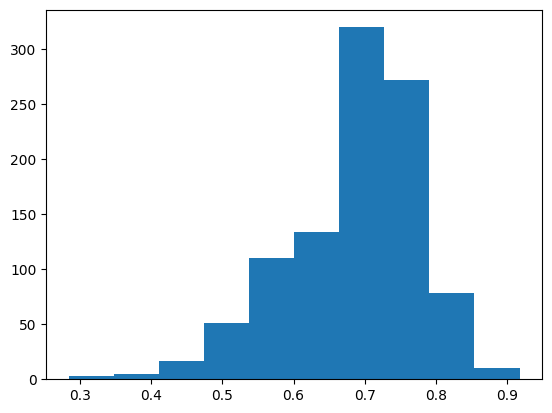

In [ ]:
# Veamos todas las predicciones de un usuario, y el plot de distribución de su rating predict

user_id = 1
user_data = np.array([user_id for i in range(len(book_data))])
predictions = model.predict([user_data, book_data])
predictions = np.array([a[0] for a in predictions])

plt.hist(predictions, bins=10)
plt.show()

(array([  950.,     0.,  6540.,     0.,     0., 23153.,     0., 69120.,
            0., 37633.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

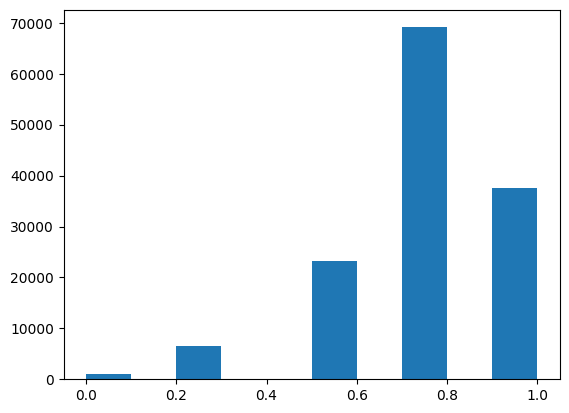

In [ ]:
predictions = np.array([mas_cercano(a) for a in predictions])

plt.hist(predictions, bins=10)

In [ ]:
#Obtenemos MAE, RMSE, MSE, utilizando test


y_true = test["rating"].values
y_pred = model.predict([np.array(test.user_id), np.array(test.book_id)])
y_pred = np.array([a[0] for a in y_pred])

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MSE de predictions redondeado: {mse}")
print(f"RMSE de predictions redondeado: {rmse}")

mae = mean_absolute_error(y_true, y_pred)
print(f"MAE de predictions redondeado: {mae}")

666/666 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSE de predictions redondeado: 0.0855376618010033
RMSE de predictions redondeado: 0.292468223574807
MAE de predictions redondeado: 0.2261679184776562


In [ ]:
loaded_model = tf.keras.models.load_model('regression_model_w_title_no_review.h5')
loaded_model.compile(optimizer='adam', loss='mean_squared_error')

562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


(array([  92.,  316.,  397.,  432.,  978., 1531., 1528., 4091., 5076.,
        3542.]),
 array([8.21274181e-04, 1.00578591e-01, 2.00335905e-01, 3.00093234e-01,
        3.99850547e-01, 4.99607861e-01, 5.99365175e-01, 6.99122488e-01,
        7.98879802e-01, 8.98637116e-01, 9.98394430e-01]),
 <BarContainer object of 10 artists>)

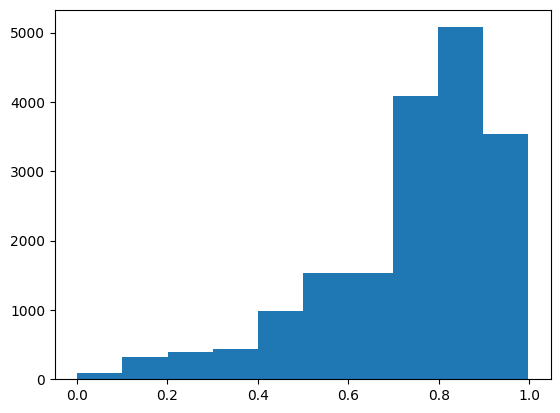

In [ ]:
predictions_normal = loaded_model.predict([np.array(test.user_id), np.array(test.book_id)])
predictions_normal = np.array([a[0] for a in predictions_normal])

plt.hist(predictions_normal, bins=10)

In [ ]:
#Calculamos MAE, RMSE, MSE

y_true = test["rating"].values
y_pred = loaded_model.predict([np.array(test.user_id), np.array(test.book_id)])
y_pred = np.array([a[0] for a in y_pred])

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MSE de predictions sin redondear: {mse}")
print(f"RMSE de predictions sin redondear: {rmse}")

mae = mean_absolute_error(y_true, y_pred)
print(f"MAE de predictions sin redondear: {mae}")

666/666 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSE de predictions sin redondear: 0.0855376618010033
RMSE de predictions sin redondear: 0.292468223574807
MAE de predictions sin redondear: 0.2261679184776562


## Modelo con user_id, book_id y reviews

https://keras.io/api/keras_nlp/base_classes/tokenizer/

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

https://www.tensorflow.org/responsible_ai/fairness_indicators/tutorials/Fairness_Indicators_TFCO_Wiki_Case_Study

In [ ]:
#review_text de train y test en str
#pasaba que a veces lo tomaba como float
train['review_text'] = train['review_text'].astype(str)
test['review_text'] = test['review_text'].astype(str)

In [ ]:
# preprocesar
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train.review_text)
review_sequences = tokenizer.texts_to_sequences(train.review_text)
review_padded = pad_sequences(review_sequences, maxlen=max_len)

# inputs de book y user
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
# input del review
text_input = Input(shape=(max_len,), name="Text-Input")
text_embedding = Embedding(max_words, 32, input_length=max_len)(text_input)
text_lstm = LSTM(64)(text_embedding)

# se combina con producto punto, y luego concatenar
prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
combined = concatenate([prod, text_lstm])

# capas
dense1 = Dense(128, activation='relu')(combined)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense2)

# modelo
model = Model([user_input, book_input, text_input], output)
model.compile(optimizer='adam', loss='mean_squared_error')

# fit
history = model.fit([train.user_id, train.book_id, review_padded], train.rating, epochs=10, verbose=1)
model.save('regression_model_with_text.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 211s 76ms/step - loss: 0.0511
Epoch 2/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 200s 76ms/step - loss: 0.0348
Epoch 3/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 201s 75ms/step - loss: 0.0244
Epoch 4/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 185s 72ms/step - loss: 0.0182
Epoch 5/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 200s 78ms/step - loss: 0.0145
Epoch 6/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 188s 72ms/step - loss: 0.0122
Epoch 7/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 187s 73ms/step - loss: 0.0105
Epoch 8/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 195s 70ms/step - loss: 0.0089
Epoch 9/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 204s 71ms/step - loss: 0.0077
Epoch 10/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 180s 70ms/step - loss: 0.0065


666/666 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step


(array([ 211.,  352.,  514.,  633., 2071., 2226., 1913., 5648., 2072.,
        5644.]),
 array([6.89151522e-04, 1.00620225e-01, 2.00551301e-01, 3.00482363e-01,
        4.00413454e-01, 5.00344515e-01, 6.00275576e-01, 7.00206637e-01,
        8.00137758e-01, 9.00068820e-01, 9.99999881e-01]),
 <BarContainer object of 10 artists>)

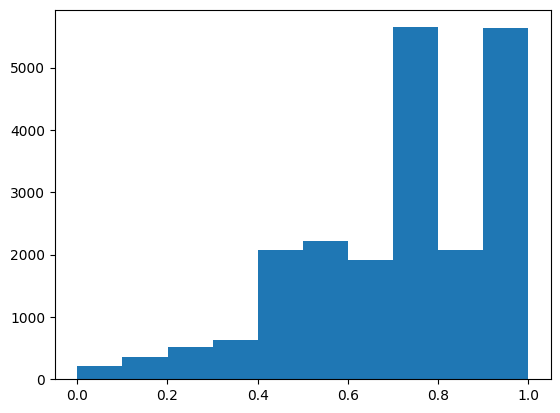

In [ ]:
# prediccion conociendo la review
test_sequences = tokenizer.texts_to_sequences(test.review_text)
test_padded = pad_sequences(test_sequences, maxlen=max_len)

predictions = model.predict([test.user_id, test.book_id, test_padded])

plt.hist(predictions, bins=10)

666/666 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step
MSE de predictions: 0.05312665399693822
RMSE de predictions: 0.23049219942752558
MAE de predictions: 0.16648408035102064


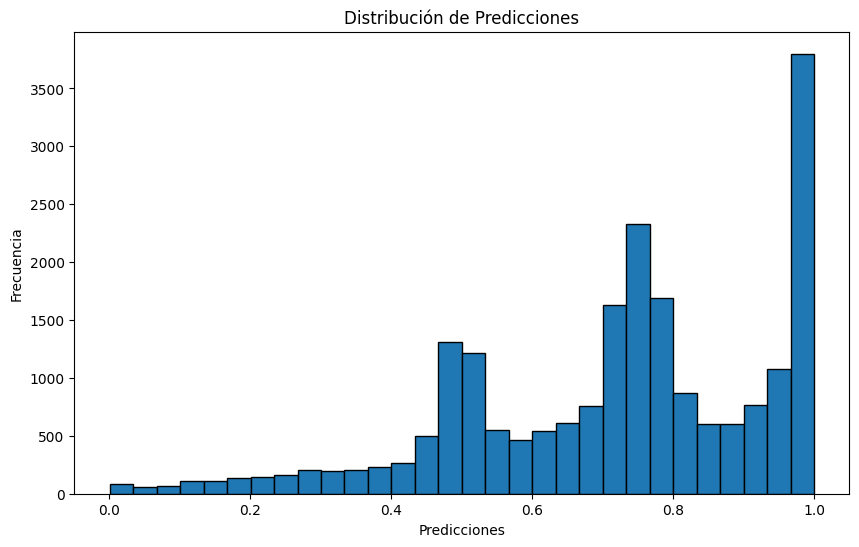

In [ ]:
predictions = model.predict([test.user_id, test.book_id, test_padded])

y_true = test["rating"].values
y_pred = predictions.flatten()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"MSE de predictions: {mse}")
print(f"RMSE de predictions: {rmse}")
print(f"MAE de predictions: {mae}")

plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=30, edgecolor='black')
plt.title('Distribución de Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# Añadamos al test una nueva columna, llamada reviews_test, donde es un simple string vacío
#la idea es simular que un usuario no tiene review para un libro
test['review_test'] = ' '
#a string
test['review_test'] = test['review_test'].astype(str)
test.head()

,user_id,book_id,review_text,rating,book_title,review_test
0,4054,236,Extremely well written in translation. Nuanced...,0.75,The Shadow of the Wind (The Cemetery of Forgot...,
1,719,878,"I admire Jenny Lawson so much, even more now t...",0.75,Furiously Happy: A Funny Book About Horrible T...,
2,3768,396,This book for me is a 4.5 stars books. I bough...,0.75,"Soulless (Parasol Protectorate, #1)",
3,4151,771,The rest of the trilogy could turn this into 5...,0.75,"Annihilation (Southern Reach, #1)",
4,6477,478,I do not understand what all the hype was abou...,0.25,The Underground Railroad,


In [ ]:
loaded_model_with_text = tf.keras.models.load_model('regression_model_with_text.h5')
loaded_model_with_text.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#test review_text a string
test['review_text'] = test['review_text'].astype(str)

666/666 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step


(array([ 424.,  656.,  678.,  814., 1344., 1583., 2075., 2827., 2986.,
        7897.]),
 array([0.00525176, 0.1047265 , 0.20420124, 0.30367598, 0.40315071,
        0.50262547, 0.60210019, 0.70157492, 0.80104971, 0.90052444,
        0.99999917]),
 <BarContainer object of 10 artists>)

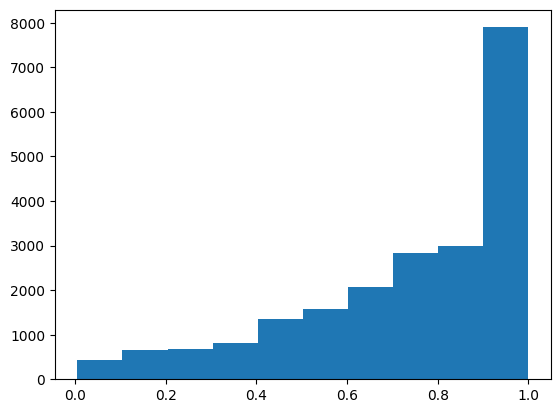

In [ ]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train.review_text)

test_sequences = tokenizer.texts_to_sequences(test.review_test)
test_padded = pad_sequences(test_sequences, maxlen=max_len)

predictions_review = loaded_model_with_text.predict([test.user_id, test.book_id, test_padded])

plt.hist(predictions_review, bins=10)

In [ ]:
#tipo de test_padded
print(type(test_padded))

<class 'numpy.ndarray'>


In [ ]:
print(test_padded.shape)

(35966, 100)


In [ ]:
test_padded

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [ ]:
predictions_review = np.array([mas_cercano(a) for a in predictions_review])

plt.hist(predictions_review, bins=10)

In [ ]:
#MAE, RMSE, MSE

y_true = test["rating"].values
y_pred = loaded_model_with_text.predict([test.user_id, test.book_id, test_padded])
y_pred = np.array([a[0] for a in y_pred])

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MSE de predictions sin redondear: {mse}")
print(f"RMSE de predictions sin redondear: {rmse}")

mae = mean_absolute_error(y_true, y_pred)
print(f"MAE de predictions sin redondear: {mae}")

666/666 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step
MSE de predictions sin redondear: 0.1245368791407531
RMSE de predictions sin redondear: 0.3528978310230216
MAE de predictions sin redondear: 0.2719770704286983


### Métricas de ranking

Para el cálculo de novedad y diversidad, tengo que utilizar books_meta_gr

In [6]:
def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k

In [7]:
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [8]:
def recall_at_k(relevant_items, recommended_items, k):
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items[:k])
    intersection = relevant_items.intersection(recommended_items)
    recall = len(intersection) / len(relevant_items) if len(relevant_items) > 0 else 0
    return recall

In [ ]:
user_item_test = test.groupby('user_id')['book_id'].apply(list).to_dict()


In [ ]:
user_item_test

{1: [92, 87, 49, 93, 82],
 2: [98, 184, 143, 131, 139, 176, 133],
 3: [94, 242],
 4: [75, 197, 247],
 5: [277, 301],
 6: [307, 310, 74, 347],
 7: [362],
 8: [372, 393, 391, 37],
 9: [185, 186, 29],
 10: [464, 326, 107],
 11: [519, 495, 170, 518],
 12: [27, 555, 94, 237, 446, 419, 527],
 13: [494, 587, 594, 597],
 14: [294, 607],
 15: [548, 413, 214],
 16: [619, 501, 75, 301, 297, 263],
 17: [114, 99, 214],
 18: [88, 92],
 19: [378, 389, 369],
 20: [486, 134],
 21: [141, 393, 124, 583, 219],
 22: [653, 206, 679, 78, 251],
 23: [358, 534, 736],
 24: [201],
 25: [763, 653, 78],
 26: [498, 740, 100],
 27: [340, 272, 13, 462, 257, 443],
 28: [30, 673, 790, 23, 109, 156, 13, 205],
 29: [807, 196, 6, 203, 741],
 30: [516, 350, 826, 619, 92],
 31: [829, 195],
 32: [184, 831, 442],
 33: [748, 195],
 34: [9, 49, 240, 140, 218, 487, 506, 620, 598, 450],
 35: [51, 512, 76, 74],
 36: [168],
 37: [275, 40, 211, 617, 730, 326],
 38: [409, 414, 346, 343],
 39: [238, 778, 135, 242, 770],
 40: [819, 883

In [ ]:
book_data = np.array(list(set(all_reviews.book_id)))
book_data

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
         34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
        100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
        111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,
        122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,
        133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
        144,  145,  146,  147,  148,  149,  150,  1

In [ ]:
def evaluate_ranking_multimodal_early(model, user_item_test, k):
    mean_ap = 0
    mean_ndcg = 0
    mean_recall = 0

    for u in tqdm(user_item_test, desc="Evaluando usuarios", unit="usuario"):
        book_data = np.array(list(set(test.book_id)))  
        user = np.array([u for i in range(len(book_data))]) 
        predictions = model.predict([user, book_data], verbose=0) 
        predictions = np.array([a[0] for a in predictions]) 
        recommended_book_ids = (-predictions).argsort()[:k]

        rel_vector = np.isin(recommended_book_ids, user_item_test[u], assume_unique=True).astype(int)

        mean_ap += average_precision_at_k(rel_vector, k)
        mean_ndcg += ndcg_at_k(rel_vector, k, len(user_item_test[u]))
        mean_recall += recall_at_k(user_item_test[u], recommended_book_ids, k)

    # Promediar métricas
    mean_ap /= len(user_item_test)
    mean_ndcg /= len(user_item_test)
    mean_recall /= len(user_item_test)

    return mean_ap, mean_ndcg, mean_recall


#https://stackoverflow.com/questions/72350446/how-can-i-stop-keras-from-printing-after-calling-model-predict

In [ ]:
ap, ndcg, recall = evaluate_ranking_multimodal_early(loaded_model, user_item_test, 10)

Evaluando usuarios: 100%|██████████| 6482/6482 [23:29<00:00,  4.60usuario/s]


In [ ]:
print(f"AP: {ap}")
print(f"NDCG: {ndcg}")
print(f"Recall: {recall}")

AP: 0.0036110866232742216
NDCG: 0.007265171913301205
Recall: 0.011424056248184612


In [ ]:
user_item_test = test.groupby('user_id')['book_id'].apply(list).to_dict()

In [ ]:
def evaluate_ranking_multimodal_reviews(model, user_item_test, k):
    max_words = 10000 
    max_len = 100

    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(train.review_text) # Se entrena con las reviews originales

    mean_ap = 0
    mean_ndcg = 0
    mean_recall = 0

    for u in tqdm(user_item_test, desc="Evaluando usuarios", unit="usuario"):
        unique_books = np.array(list(set(test.book_id)))

        # la idea del df, es simular que es como train o test, pero con reviews vacíos
        book_data_df = pd.DataFrame({
            'user_id': [u for _ in range(len(unique_books))],
            'book_id': unique_books,
            'review_text': [''] * len(unique_books)
        })
        book_data_df["review_text"] = book_data_df["review_text"].astype(str)

        empty_reviews = tokenizer.texts_to_sequences(book_data_df.review_text)
        empty_reviews_padded = pad_sequences(empty_reviews, maxlen=max_len)

        predictions = model.predict([book_data_df.user_id, book_data_df.book_id, empty_reviews_padded], verbose=0)
        predictions = np.array([a[0] for a in predictions])
        recommended_book_ids = (-predictions).argsort()[:k]

        rel_vector = np.isin(recommended_book_ids, user_item_test[u], assume_unique=True).astype(int)

        mean_ap += average_precision_at_k(rel_vector, k)
        mean_ndcg += ndcg_at_k(rel_vector, k, len(user_item_test[u]))
        mean_recall += recall_at_k(user_item_test[u], recommended_book_ids, k)

    mean_ap /= len(user_item_test)
    mean_ndcg /= len(user_item_test)
    mean_recall /= len(user_item_test)

    return mean_ap, mean_ndcg, mean_recall

ap_reviews, ndcg_reviews, recall_reviews = evaluate_ranking_multimodal_reviews(loaded_model_with_text, user_item_test, 10)

Evaluando usuarios: 100%|██████████| 6482/6482 [1:37:22<00:00,  1.11usuario/s]


In [ ]:
print(f"AP con reviews: {ap_reviews}")
print(f"NDCG con reviews: {ndcg_reviews}")
print(f"Recall con reviews: {recall_reviews}")

AP con reviews: 0.0035398759935939814
NDCG con reviews: 0.006375759938909658
Recall con reviews: 0.009135326687779643


Diversidad

In [ ]:
user = 1
ranking_normal = loaded_model.predict([np.array([user for i in range(len(book_data))]), book_data])
ranking_normal = np.array([a[0] for a in ranking_normal])

#tomamos top 10
top_10_normal = np.argsort(ranking_normal)[-10:]
print(f"El top 10 de libros para el usuario {user} es: {top_10_normal}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
El top 10 de libros para el usuario 1 es: [ 56 780 983 674 989 866 815 238 744 576]


In [87]:
books_meta_gr

[{'book_id': '5333265',
  'genres': {'history, historical fiction, biography': 1}},
 {'book_id': '1333909',
  'genres': {'fiction': 219, 'history, historical fiction, biography': 5}},
 {'book_id': '7327624',
  'genres': {'fantasy, paranormal': 31,
   'fiction': 8,
   'mystery, thriller, crime': 1,
   'poetry': 1}},
 {'book_id': '6066819',
  'genres': {'fiction': 555, 'romance': 23, 'mystery, thriller, crime': 10}},
 {'book_id': '287140', 'genres': {'non-fiction': 3}},
 {'book_id': '287141',
  'genres': {'history, historical fiction, biography': 9,
   'children': 6,
   'fantasy, paranormal': 1,
   'fiction': 1,
   'young-adult': 1}},
 {'book_id': '378460', 'genres': {'fiction': 2}},
 {'book_id': '6066812',
  'genres': {'fantasy, paranormal': 32,
   'young-adult': 8,
   'fiction': 7,
   'children': 16}},
 {'book_id': '34883016', 'genres': {'romance': 3}},
 {'book_id': '287149',
  'genres': {'non-fiction': 24, 'history, historical fiction, biography': 1}},
 {'book_id': '6066814',
  'genre

In [90]:
#Para los géneros, tomemos solamente el primero que salga en el dict
#{'fiction': 555, 'romance': 23}. Ahí solo tomamos fiction
books_meta_gr['genres'] = books_meta_gr['genres'].apply(
    lambda x: list(x.keys())[0] if isinstance(x, dict) and x else None
)

In [91]:
books_meta_gr

,book_id,genres
0,5333265,"history, historical fiction, biography"
1,1333909,fiction
2,7327624,"fantasy, paranormal"
3,6066819,fiction
4,287140,non-fiction
...,...,...
2360650,3084038,non-fiction
2360651,26168430,"mystery, thriller, crime"
2360652,2342551,poetry
2360653,22017381,romance


In [92]:
books_meta_gr = books_meta_gr.set_index('book_id')

In [93]:
books_meta_gr

,genres
book_id,
5333265,"history, historical fiction, biography"
1333909,fiction
7327624,"fantasy, paranormal"
6066819,fiction
287140,non-fiction
...,...
3084038,non-fiction
26168430,"mystery, thriller, crime"
2342551,poetry


In [94]:
item_counts = train["book_id"].value_counts()
total_interacciones = len(train)
items_popularity = item_counts / total_interacciones
items_popularity = items_popularity.to_dict()

In [96]:
books_meta_gr['genres']

,genres
book_id,
5333265,"history, historical fiction, biography"
1333909,fiction
7327624,"fantasy, paranormal"
6066819,fiction
287140,non-fiction
...,...
3084038,non-fiction
26168430,"mystery, thriller, crime"
2342551,poetry


In [ ]:
def diversity(recommended_items, item_categories):
  #Tiene try except, porque hubo unos problemas en la primera implementación
  unique_categories = set()
  for item in recommended_items:
    try:
      item_id = list(book_id_map.keys())[list(book_id_map.values()).index(item)]
    except ValueError:
      continue
    item_id = str(item_id)
    if item_id not in item_categories.index:
      continue

    categories = item_categories.loc[item_id]
    if categories is None:
      continue

    # Dividir las categorías si están separadas por comas
    category_list = [cat.strip() for cat in categories.split(',')]

    unique_categories.update(category_list)
  return len(unique_categories) / len(recommended_items)


item_counts = train["book_id"].value_counts()
total_interacciones = len(train)
items_popularity = item_counts / total_interacciones
items_popularity = items_popularity.to_dict()

def novelty(recommended_items, item_popularity):
  novelty_score = 0
  for item in recommended_items:
    if item not in items_popularity:
      continue
    novelty_score += np.log(1 / items_popularity[item])
  return novelty_score

In [ ]:
diversidad = diversity(top_10_normal, books_meta_gr['genres'])
print(f"La diversidad del top 10 sin reviews es: {diversidad}")

novedad = novelty(top_10_normal, items_popularity)
print(f"La novedad del top 10 sin reviews es: {novedad}")

La diversidad del top 10 sin reviews es: 0.2
La novedad del top 10 sin reviews es: 71.05053715185002


In [ ]:

diversidad_total_normal = []
novedad_total_normal = []

for user in tqdm(user_item_test, desc="Procesando usuarios"):
    ranking_normal = loaded_model.predict([np.array([user for i in range(len(book_data))]), book_data], verbose=0)
    ranking_normal = np.array([a[0] for a in ranking_normal])
    top_10_normal = np.argsort(ranking_normal)[-10:]
    # print(f"El top 10 de libros para el usuario {user} es: {top_10_normal}")
    diversidad_total_normal.append(diversity(top_10_normal, books_meta_gr['genres']))
    novedad_total_normal.append(novelty(top_10_normal, items_popularity))

diversidad_total_normal = np.mean(diversidad_total_normal)
novedad_total_normal = np.mean(novedad_total_normal)

print("*"*50)
print(f"La diversidad total sin reviews es: {diversidad_total_normal}")
print(f"La novedad total sin reviews es: {novedad_total_normal}")


Procesando usuarios: 100%|██████████| 6482/6482 [22:30<00:00,  4.80it/s]

**************************************************
La diversidad total sin reviews es: 0.5668620796050601
La novedad total sin reviews es: 70.84701469502488


Ahora para modelo con reviews

In [ ]:

loaded_model_with_text = load_model('regression_model_with_text.h5', compile=False)
loaded_model_with_text.compile(optimizer='adam', loss='mean_squared_error')


666/666 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step


(array([ 424.,  656.,  678.,  814., 1344., 1583., 2075., 2827., 2986.,
        7897.]),
 array([0.00525176, 0.1047265 , 0.20420124, 0.30367598, 0.40315071,
        0.50262547, 0.60210019, 0.70157492, 0.80104971, 0.90052444,
        0.99999917]),
 <BarContainer object of 10 artists>)

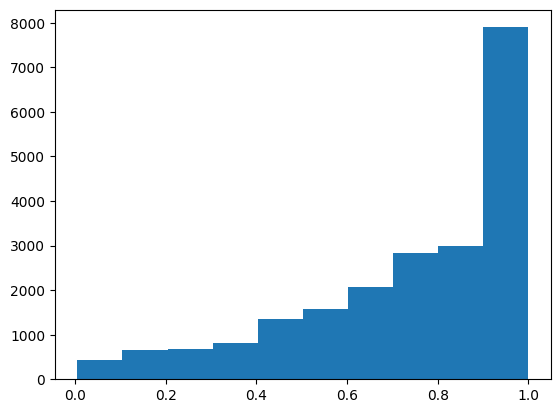

In [ ]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
train["review_text"] = train["review_text"].astype(str)
tokenizer.fit_on_texts(train.review_text)

test_sequences = tokenizer.texts_to_sequences(test.review_test)
test_padded = pad_sequences(test_sequences, maxlen=max_len)

predictions_review = loaded_model_with_text.predict([test.user_id, test.book_id, test_padded])

plt.hist(predictions_review, bins=10)

In [ ]:
from tqdm.auto import tqdm
#Sin el auto se imprimía raro
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train.review_text)

diversidad_total_reviews = []
novedad_total_reviews = []

for u in tqdm(user_item_test, desc="Procesando usuarios con reviews vacías", unit="usuario"):
    unique_books = np.array(list(set(test.book_id)))

    # simulador de reviews vacías
    book_data_df = pd.DataFrame({
        'user_id': [u for _ in range(len(unique_books))],
        'book_id': unique_books,
        'review_text': [''] * len(unique_books)
    })
    book_data_df["review_text"] = book_data_df["review_text"].astype(str)
    empty_reviews = tokenizer.texts_to_sequences(book_data_df.review_text)
    empty_reviews_padded = pad_sequences(empty_reviews, maxlen=max_len)

    user = np.array([u for _ in range(len(unique_books))])
    predictions = model.predict([book_data_df.user_id, book_data_df.book_id, empty_reviews_padded], verbose=0)
    predictions = np.array([a[0] for a in predictions])
    top_10_review = np.argsort(predictions)[-10:]
    # print(f"El top 10 de libros para el usuario {user} es: {top_10_review}")

    diversidad_total_reviews.append(diversity(top_10_review, books_meta_gr['genres']))
    novedad_total_reviews.append(novelty(top_10_review, items_popularity))

diversidad_total_reviews = np.mean(diversidad_total_reviews)
novedad_total_reviews = np.mean(novedad_total_reviews)

print(f"La diversidad total con reviews vacías es: {diversidad_total_reviews}")
print(f"La novedad total con reviews vacías es: {novedad_total_reviews}")


Procesando usuarios con reviews vacías:   0%|          | 0/6482 [00:00<?, ?usuario/s]

  0%|          | 0/6482 [20:29<?, ?it/s]


La diversidad total con reviews vacías es: 0.6200555384140697
La novedad total con reviews vacías es: 71.33827101155009


# Post-Posters
https://keras.io/keras_hub/api/models/bert/bert_tokenizer/

https://www.kaggle.com/models/tensorflow/bert/tensorFlow2/en-uncased-l-12-h-768-a-12/3

https://chatgpt.com/share/6755ea98-9700-8005-a608-b9f74a783e46

Estuve mucho rato peleando con que funcionara, así que al final simplemente le mandé toda la página como contexto

## Modelo utilizando book_title, book_id y user_id. 

Para book_title se utilizo Bert

In [ ]:
# Configuración de BertTokenizer
tokenizer = BertTokenizer.from_preset("bert_base_en_uncased")

# tokenizar
book_titles = train.book_title.tolist()
book_tokenized = tokenizer(book_titles)
book_tokenized = tf.keras.preprocessing.sequence.pad_sequences(book_tokenized, maxlen=20)

# Inputs del modelo
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books + 1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# Input de títulos tokenizados con Bert. El 20 es por el maxlen
title_input = Input(shape=(20,), name="Title-Input")
title_embedding = Embedding(input_dim=len(tokenizer.vocabulary), output_dim=32, name="Title-Embedding")(title_input)
title_lstm = Bidirectional(LSTM(64))(title_embedding)

# Combinación de vectores
prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
combined = concatenate([prod, title_lstm])

# Capas densas
dense1 = Dense(128, activation='relu')(combined)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense2)

# Modelo final
model = Model([user_input, book_input, title_input], output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Ajuste del modelo
history = model.fit(
    [train.user_id, train.book_id, book_tokenized],
    train.rating,
    epochs=10,
    verbose=1
)

model.save('regression_model_with_titles.h5')

100%|██████████| 510/510 [00:00<00:00, 128kB/s]


100%|██████████| 547/547 [00:00<00:00, 155kB/s]


100%|██████████| 226k/226k [00:00<00:00, 1.00MB/s]


Epoch 1/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 132s 49ms/step - loss: 0.0633
Epoch 2/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 119s 40ms/step - loss: 0.0566
Epoch 3/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 148s 43ms/step - loss: 0.0440
Epoch 4/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 112s 43ms/step - loss: 0.0370
Epoch 5/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 104s 40ms/step - loss: 0.0331
Epoch 6/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 107s 41ms/step - loss: 0.0306
Epoch 7/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 106s 41ms/step - loss: 0.0293
Epoch 8/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 141s 41ms/step - loss: 0.0275
Epoch 9/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 103s 40ms/step - loss: 0.0265
Epoch 10/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 106s 41ms/step - loss: 0.0256


In [ ]:

# Preprocesamiento de los títulos de libros del conjunto de prueba
book_titles_test = test.book_title.tolist()
book_tokenized_test = tokenizer(book_titles_test)
book_tokenized_test = tf.keras.preprocessing.sequence.pad_sequences(book_tokenized_test, maxlen=20)

# Etiquetas verdaderas
y_true = test.rating

# Predicciones del modelo
y_pred = model.predict([test.user_id, test.book_id, book_tokenized_test])

# Cálculo de métricas
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)

# Mostrar resultados
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")


666/666 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step
MAE: 0.22133196590146587
RMSE: 0.28846285559385143
MSE: 0.08321081905735919


Probando poner titulos junto al book_id

In [ ]:

tokenizer = BertTokenizer.from_preset("bert_base_en_uncased")

book_titles = train.book_title.tolist()
book_tokenized = tokenizer(book_titles)
book_tokenized = tf.keras.preprocessing.sequence.pad_sequences(book_tokenized, maxlen=20)

book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books + 1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users + 1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

title_input = Input(shape=(20,), name="Title-Input")
title_embedding = Embedding(input_dim=len(tokenizer.vocabulary), output_dim=32, name="Title-Embedding")(title_input)
title_lstm = Bidirectional(LSTM(64))(title_embedding)

# concatenamos antes
book_title_combined = concatenate([book_vec, title_lstm], name="Book-Title-Combined")

# Reducir la dimensionalidad del tensor combinado a la de user_vec (5)
book_title_combined_reduced = Dense(5, activation='relu', name="Reduce-Dim")(book_title_combined)

prod = Dot(name="Dot-Product", axes=1)([book_title_combined_reduced, user_vec])

dense1 = Dense(128, activation='relu')(prod)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1, activation='sigmoid')(dense2)

model = Model([user_input, book_input, title_input], output)
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    [train.user_id, train.book_id, book_tokenized],
    train.rating,
    epochs=10,
    verbose=1
)

model.save('regression_model_with_titles_reduced.h5')



Epoch 1/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 134s 49ms/step - loss: 0.0677
Epoch 2/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 122s 41ms/step - loss: 0.0653
Epoch 3/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 142s 41ms/step - loss: 0.0648
Epoch 4/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 140s 40ms/step - loss: 0.0649
Epoch 5/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 138s 39ms/step - loss: 0.0662
Epoch 6/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 141s 38ms/step - loss: 0.0646
Epoch 7/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 155s 43ms/step - loss: 0.0656
Epoch 8/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 102s 39ms/step - loss: 0.0649
Epoch 9/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 141s 39ms/step - loss: 0.0648
Epoch 10/10
2576/2576 ━━━━━━━━━━━━━━━━━━━━ 141s 39ms/step - loss: 0.0650


In [ ]:
# Preprocesamiento de los títulos de libros del conjunto de prueba
book_titles_test = test.book_title.tolist()
book_tokenized_test = tokenizer(book_titles_test)
book_tokenized_test = tf.keras.preprocessing.sequence.pad_sequences(book_tokenized_test, maxlen=20)

y_true = test.rating

print(f"Shape de user_id: {test.user_id.shape}")
print(f"Shape de book_id: {test.book_id.shape}")
print(f"Shape de book_tokenized_test: {book_tokenized_test.shape}")

print(f"Tipo de user_id: {type(test.user_id)}")
print(f"Tipo de book_id: {type(test.book_id)}")
print(f"Tipo de book_tokenized_test: {type(book_tokenized_test)}")

y_pred = model.predict([test.user_id, test.book_id, book_tokenized_test])

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)

print(f"MAE con title junto a book_id: {mae}")
print(f"RMSE con title junto a book_id: {rmse}")
print(f"MSE con title junto a book_id: {mse}")


Shape de user_id: (21284,)
Shape de book_id: (21284,)
Shape de book_tokenized_test: (21284, 20)
Tipo de user_id: <class 'pandas.core.series.Series'>
Tipo de book_id: <class 'pandas.core.series.Series'>
Tipo de book_tokenized_test: <class 'numpy.ndarray'>
666/666 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
MAE con title junto a book_id: 0.19712954603893107
RMSE con title junto a book_id: 0.25607487680172764
MSE con title junto a book_id: 0.06557434252901999


In [24]:
#https://media.githubusercontent.com/media/ssilvapinochet/RecSysData/refs/heads/main/Archivos%20finales/all_reviews_df.csv
#https://raw.githubusercontent.com/ssilvapinochet/RecSysData/refs/heads/main/Archivos%20finales/book_id_map_10k.json
#https://media.githubusercontent.com/media/ssilvapinochet/RecSysData/refs/heads/main/Archivos%20finales/test_w_title.csv
#https://media.githubusercontent.com/media/ssilvapinochet/RecSysData/refs/heads/main/Archivos%20finales/train_w_title.csv
#https://raw.githubusercontent.com/ssilvapinochet/RecSysData/refs/heads/main/Archivos%20finales/user_id_map_10k.json

all_reviews_df = pd.read_csv("https://media.githubusercontent.com/media/ssilvapinochet/RecSysData/refs/heads/main/Archivos%20finales/all_reviews_df.csv")
#Nos quedamos con user_id, book_id, rating, review_text y book_title
all_reviews = all_reviews_df[['user_id', 'book_id', 'review_text', 'rating', 'book_title']]
all_reviews.loc[:, "rating"] = (all_reviews["rating"].astype(float) - 1) / 4
all_reviews.head()

<ipython-input-24-42180d78c511>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.25 0.75 0.5  ... 1.   1.   0.75]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_reviews.loc[:, "rating"] = (all_reviews["rating"].astype(float) - 1) / 4


,user_id,book_id,review_text,rating,book_title
0,4672eb229c808b792b8ea95f01f19784,7171637,"Second read, I dropped one star. I remember ho...",0.25,"Clockwork Angel (The Infernal Devices, #1)"
1,4672eb229c808b792b8ea95f01f19784,7735333,I'm going to read this to finish up my dypstop...,0.75,"Matched (Matched, #1)"
2,4672eb229c808b792b8ea95f01f19784,3,I remember trying 3 times to read this but I a...,0.50,Harry Potter and the Sorcerer's Stone (Harry P...
3,4672eb229c808b792b8ea95f01f19784,13618440,The lore in this series is incredible. I absol...,0.75,Dreams of Gods & Monsters (Daughter of Smoke &...
4,4672eb229c808b792b8ea95f01f19784,24120519,3.5 stars. Took me forever to read this becaus...,0.50,Library of Souls (Miss Peregrine's Peculiar Ch...


In [ ]:
#https://stackoverflow.com/questions/12965203/how-to-get-json-from-webpage-into-python-script
with urllib.request.urlopen("https://raw.githubusercontent.com/ssilvapinochet/RecSysData/refs/heads/main/Archivos%20finales/user_id_map_10k.json") as url:
  user_id_map = json.load(url)
  print(user_id_map)

with urllib.request.urlopen("https://raw.githubusercontent.com/ssilvapinochet/RecSysData/refs/heads/main/Archivos%20finales/book_id_map_10k.json") as url:
  book_id_map = json.load(url)
  print(book_id_map)

{'4672eb229c808b792b8ea95f01f19784': 1, '4a44f603cc3df339acc48590044a2db0': 2, 'dea5bda3eaee375c4ab59fd399bc37db': 3, '5cca1dd30cd5a98c1c8e731839265ccf': 4, '34216df2a5f3846b17e3f96bea6c2ad7': 5, 'db5bc9792b1f5b25e8d9d4799e215446': 6, 'd69935ed03b527d553c979ffa548659f': 7, '792500e85277fa7ada535de23e7eb4c3': 8, 'd8c86e725d683042e9eec675f294d7d4': 9, 'e8a8e8152ee8def16bc90b306be7caf2': 10, 'fc0a0792fd1c30427acdbfecbf5b0a20': 11, 'ab2fadb5c7bbe55c80406d2b3692e969': 12, '246eac0ca4d02e73d8768a5acb9b89d7': 13, '91eb0f8d12bcc01204862181f3e2b3b2': 14, '9ece969fdfbcea1d659cadfd329020a8': 15, '3b3f26019b3a5dbecb49c5faf1abce4c': 16, '90c53a2210f33ada709caa5aed0993c2': 17, '929a819434fe1182015b4b95c1149346': 18, 'ef5df7f9065022d65810776875a6d0c3': 19, 'fdc12d21a19b9c69b479a2b62cd6fa53': 20, 'f9d166ab9038f2ea54dff7c639cc7cd2': 21, 'ed4ecf39b59b9d04ac88cd57566c1135': 22, '9aadbd5a6cc0b41ff0f65b3d8dda3827': 23, 'b3339e93450363e6fc61e60f5ba022bf': 24, '9f30590bdd5c8860cb36c8d02ab30fac': 25, '2d43e0a

In [26]:
#Ahora usamos user_id_map_10k.json y book_id_map_10k.json para transformar los ids
#{'4672eb229c808b792b8ea95f01f19784': 1, '4a44f603cc3df339acc48590044a2db0': 2,

all_reviews.loc[:, "user_id"] = all_reviews["user_id"].map(user_id_map)

all_reviews.loc[:, "book_id"] = all_reviews["book_id"].astype(str)
all_reviews.loc[:, "book_id"] = all_reviews["book_id"].map(book_id_map)

#values de book_id en all_reviews
all_reviews['user_id'].unique()

<ipython-input-26-ad3f9464a7c7>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['7171637' '7735333' '3' ... '43641' '37470' '12232938']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_reviews.loc[:, "book_id"] = all_reviews["book_id"].astype(str)


array([1, 2, 3, ..., 6786, 6787, 6788], dtype=object)

In [40]:
train = pd.read_csv("https://media.githubusercontent.com/media/ssilvapinochet/RecSysData/refs/heads/main/Archivos%20finales/train_w_title.csv")
test = pd.read_csv("https://media.githubusercontent.com/media/ssilvapinochet/RecSysData/refs/heads/main/Archivos%20finales/test_w_title.csv")

In [41]:
print(f"Usuarios unicos en train: {len(train.user_id.unique())}")
print(f"Libros unicos en train: {len(train.book_id.unique())}")

print(f"Usuarios unicos en test: {len(test.user_id.unique())}")
print(f"Libros unicos en test: {len(test.book_id.unique())}")

Usuarios unicos en train: 6786
Libros unicos en train: 996
Usuarios unicos en test: 6482
Libros unicos en test: 994


In [ ]:

loaded_model_title = load_model('regression_model_with_titles_reduced.h5', compile=False)
loaded_model_title.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
tokenizer = BertTokenizer.from_preset("bert_base_en_uncased")

book_titles_test = test.book_title.tolist()
book_tokenized_test = tokenizer(book_titles_test)
book_tokenized_test = tf.keras.preprocessing.sequence.pad_sequences(book_tokenized_test, maxlen=20)

# print(book_tokenized_test.shape)

y_true = test.rating

y_pred = loaded_model_title.predict([test.user_id, test.book_id, book_tokenized_test])

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse = mean_squared_error(y_true, y_pred)

print(f"MAE con title junto a book_id: {mae}")
print(f"RMSE con title junto a book_id: {rmse}")
print(f"MSE con title junto a book_id: {mse}")

(21284, 20)
666/666 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
MAE con title junto a book_id: 0.19712954603893107
RMSE con title junto a book_id: 0.25607487680172764
MSE con title junto a book_id: 0.06557434252901999


In [45]:
user_item_test = test.groupby('user_id')['book_id'].apply(list).to_dict()
user_item_test

{1: [92, 87, 49, 93, 82],
 2: [98, 184, 143, 131, 139, 176, 133],
 3: [94, 242],
 4: [75, 197, 247],
 5: [277, 301],
 6: [307, 310, 74, 347],
 7: [362],
 8: [372, 393, 391, 37],
 9: [185, 186, 29],
 10: [464, 326, 107],
 11: [519, 495, 170, 518],
 12: [27, 555, 94, 237, 446, 419, 527],
 13: [494, 587, 594, 597],
 14: [294, 607],
 15: [548, 413, 214],
 16: [619, 501, 75, 301, 297, 263],
 17: [114, 99, 214],
 18: [88, 92],
 19: [378, 389, 369],
 20: [486, 134],
 21: [141, 393, 124, 583, 219],
 22: [653, 206, 679, 78, 251],
 23: [358, 534, 736],
 24: [201],
 25: [763, 653, 78],
 26: [498, 740, 100],
 27: [340, 272, 13, 462, 257, 443],
 28: [30, 673, 790, 23, 109, 156, 13, 205],
 29: [807, 196, 6, 203, 741],
 30: [516, 350, 826, 619, 92],
 31: [829, 195],
 32: [184, 831, 442],
 33: [748, 195],
 34: [9, 49, 240, 140, 218, 487, 506, 620, 598, 450],
 35: [51, 512, 76, 74],
 36: [168],
 37: [275, 40, 211, 617, 730, 326],
 38: [409, 414, 346, 343],
 39: [238, 778, 135, 242, 770],
 40: [819, 883

Lo de book_title y el mapeo, lo hizo gemini en el colab. 

In [ ]:
#Aquí se evalua todo de una

def evaluate_ranking_multimodal_title(loaded_model_title, user_item_test, k):
    mean_ap = 0
    mean_ndcg = 0
    mean_recall = 0
    diversidad_total_reviews = []
    novedad_total_reviews = []

    for u in tqdm(user_item_test, desc="Evaluando usuarios", unit="usuario"):
        # Crear un mapeo de títulos de libros a IDs únicos
        book_title_to_id = test.groupby('book_title')['book_id'].first().reset_index()

        # Simular el DataFrame
        temp_df = pd.DataFrame({
            "user_id": pd.Series([u] * len(test.book_title.unique())),
            "book_id": book_title_to_id[book_title_to_id["book_title"].isin(test.book_title.unique())]["book_id"],
            "book_title": book_title_to_id[book_title_to_id["book_title"].isin(test.book_title.unique())]["book_title"]
        })

        book_tokenized_test = tokenizer(temp_df["book_title"].tolist())
        book_tokenized_test = tf.keras.preprocessing.sequence.pad_sequences(book_tokenized_test, maxlen=20)

        predictions = loaded_model_title.predict([
            temp_df["user_id"],
            temp_df["book_id"],
            book_tokenized_test
        ], verbose=0)

        predictions = np.array([a[0] for a in predictions])

        recommended_book_indices = (-predictions).argsort()[:k]
        recommended_book_ids = temp_df.iloc[recommended_book_indices]["book_id"].values

        #gemini
        user_books = user_item_test[u]
        rel_vector = np.isin(recommended_book_ids, user_books, assume_unique=True).astype(int)

        mean_ap += average_precision_at_k(rel_vector, k)
        mean_ndcg += ndcg_at_k(rel_vector, k, len(user_books))
        mean_recall += recall_at_k(user_books, recommended_book_ids, k)

        top_10_review = recommended_book_indices

        diversidad_reviews = diversity(top_10_review, books_meta_gr["genres"])
        novedad_reviews = novelty(top_10_review, items_popularity)

        diversidad_total_reviews.append(diversidad_reviews)
        novedad_total_reviews.append(novedad_reviews)

    mean_ap /= len(user_item_test)
    mean_ndcg /= len(user_item_test)
    mean_recall /= len(user_item_test)

    diversidad_total_reviews = np.mean(diversidad_total_reviews)
    novedad_total_reviews = np.mean(novedad_total_reviews)

    return {
        "mean_ap": mean_ap,
        "mean_ndcg": mean_ndcg,
        "mean_recall": mean_recall,
        "diversidad": diversidad_total_reviews,
        "novedad": novedad_total_reviews
    }

resultados = evaluate_ranking_multimodal_title(loaded_model_title, user_item_test, 10)



Evaluando usuarios: 100%|██████████| 6482/6482 [51:23<00:00,  2.10usuario/s]

Mean Average Precision (MAP) con títulos: 0.0019075596401267466
Normalized Discounted Cumulative Gain (NDCG) con títulos: 0.004983100012255787
Recall con títulos: 0.009619840374237177
Diversidad total de recomendaciones: 0.8
Novedad total de recomendaciones: 76.76790244544839


In [102]:
# Mostrar resultados
print(f"MAP con títulos: {resultados['mean_ap']}")
print(f"NDCG con títulos: {resultados['mean_ndcg']}")
print(f"Recall con títulos: {resultados['mean_recall']}")
print(f"Diversidad total de recomendaciones: {resultados['diversidad']}")
print(f"Novedad total de recomendaciones: {resultados['novedad']}")

MAP con títulos: 0.0019075596401267466
NDCG con títulos: 0.004983100012255787
Recall con títulos: 0.009619840374237177
Diversidad total de recomendaciones: 0.8
Novedad total de recomendaciones: 76.76790244544839
